### **Importing Libraries**

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from itertools import combinations
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

First i will transform the json file of the train_fraud_labels.json into train_fraud_labels.csv so that i can visualize it better.

In [ ]:
# Load the JSON file
json_file_path = "train_fraud_labels.json"
with open(json_file_path, "r") as file:
    data = json.load(file)

# Extract the target dictionary
target_data = data["target"]

# Convert to DataFrame
df = pd.DataFrame(list(target_data.items()), columns=["id", "Target"])

# Save as CSV
csv_file_path = "train_fraud_labels.csv"
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved as {csv_file_path}")

CSV file saved as train_fraud_labels.csv


### **Data Ingestion, Preprocessing, and Cleaning**

I will merge (inner join) both train_fraud_labels.csv with transactions_data.csv on PK(id)

In [2]:
transactions = pd.read_csv("transactions_data.csv")  # Transaction details
fraud_labels = pd.read_csv("train_fraud_labels.csv")  # Fraud labels (Target variable is here which is Yes/No)

# Merge on 'id' (transaction ID)
df = transactions.merge(fraud_labels, on="id", how="inner") #inner join since we dont need the blank values

Okay we can see that the merge is successful.

In [3]:
df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,Target
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,No
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914958,23761862,2019-10-31 23:54:00,672,5001,$12.93,Chip Transaction,47508,Cosby,TN,37722.0,7230,NaN,No
8914959,23761863,2019-10-31 23:54:00,1384,3723,$67.01,Chip Transaction,58136,Williamson,GA,30292.0,5812,NaN,No
8914960,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN,No
8914961,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN,No


In [ ]:
df['Target'].value_counts()

,count
Target,
No,8901631
Yes,13332


@modelers watch out we have a small amount of Yes compared to No. Since fraud is often rare, we need to ***handle class imbalance*** effectively which will be key to building a robust model.

-->Only 0.15% of transactions are fraud!
This confirms we’ll need class imbalance handling (e.g., SMOTE, undersampling, weighted models).

In [ ]:
df.isnull().sum()

,0
id,0
date,0
client_id,0
card_id,0
amount,0
use_chip,0
merchant_id,0
merchant_city,0
merchant_state,1047865
zip,1107377


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
 12  Target          object 
dtypes: float64(1), int64(5), object(7)
memory usage: 884.2+ MB


In [3]:
# Preprocessing:

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert 'amount' to numeric (removing '$' sign)
df['amount'] = df['amount'].replace('[$,]', '', regex=True).astype(float)

# Convert 'Target' to binary (Yes → 1, No → 0)
df['Target'] = df['Target'].str.strip().str.lower().map({'yes': 1, 'no': 0})

In [ ]:
df.dtypes

,0
id,int64
date,datetime64[ns]
client_id,int64
card_id,int64
amount,float64
use_chip,object
merchant_id,int64
merchant_city,object
merchant_state,object
zip,float64


In [ ]:
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,Target
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,0
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,0
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,0


In [ ]:
print(df['Target'].value_counts())

Target
0    8901631
1      13332
Name: count, dtype: int64


I will merge the users_data.csv datasets now.

In [4]:
users = pd.read_csv("users_data.csv")

# Merge users data
df = df.merge(users, left_on="client_id", right_on="id", how="left")  # Left join to keep all transactions
df.drop(columns=['id_y'], inplace=True)  # Drop the redundant user ID column
df.rename(columns={'id_x': 'id'}, inplace=True)  # Rename 'id_x' back to 'id'

In [6]:
df.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'Target', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards'],
      dtype='object')

In [ ]:
df.isnull().sum() # Check for new missing values

,0
id,0
date,0
client_id,0
card_id,0
amount,0
use_chip,0
merchant_id,0
merchant_city,0
merchant_state,1047865
zip,1107377


In [ ]:
df.shape

(8914963, 26)

In [ ]:
df.info()  # Shows column names, data types, and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 26 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   date               datetime64[ns]
 2   client_id          int64         
 3   card_id            int64         
 4   amount             float64       
 5   use_chip           object        
 6   merchant_id        int64         
 7   merchant_city      object        
 8   merchant_state     object        
 9   zip                float64       
 10  mcc                int64         
 11  errors             object        
 12  Target             int64         
 13  current_age        int64         
 14  retirement_age     int64         
 15  birth_year         int64         
 16  birth_month        int64         
 17  gender             object        
 18  address            object        
 19  latitude           float64       
 20  longitude          float

In [5]:
# Preprocessing on the final merged dataset:

# Remove '$' and ',' from currency columns and convert to float
currency_columns = ['per_capita_income', 'yearly_income', 'total_debt']

for col in currency_columns:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Convert 'gender' to lowercase and strip spaces
df['gender'] = df['gender'].str.strip().str.lower()

# Convert 'use_chip' to categorical
df['use_chip'] = df['use_chip'].astype('category')

# Check unique values after standardization
print(df['gender'].unique())
print(df['use_chip'].unique())

['female' 'male']
['Swipe Transaction', 'Online Transaction', 'Chip Transaction']
Categories (3, object): ['Chip Transaction', 'Online Transaction', 'Swipe Transaction']


Now i want to check if the date (year, month, day, hour) impact fraud. For instance maybe fraud patterns depend on time (e.g. fraud happens more at night or during weekends). If not i will drop the date column.

In [6]:
df['transaction_hour'] = df['date'].dt.hour
fraud_rate_per_hour = df.groupby('transaction_hour')['Target'].mean().reset_index()

fig = px.bar(
    fraud_rate_per_hour,
    x='transaction_hour',
    y='Target',
    title="Fraud Rate by Hour of Transaction",
    labels={'transaction_hour': 'Transaction Hour', 'Target': 'Fraud Rate'},
    text_auto=True,
    color='Target',
    color_continuous_scale='Reds'
)

fig.update_layout(
    xaxis_title="Transaction Hour",
    yaxis_title="Fraud Rate",
    template="plotly_dark",
    hovermode="x unified"
)

fig.show()

From this bar chart, we observe that fraud rates vary significantly by hour:

Fraud is lowest during late-night hours (0 AM - 2 AM).
Fraud peaks between 10 AM - 12 PM.
Fraud starts to decline after 7 PM, and is almost non-existent late at night.

Since fraud patterns are time-dependent, I will keep the transaction_hour column.

In [7]:
# Handling Missing Values:

# Drop the 'date' column since we no longer need it
# df.drop(columns=['date'], inplace=True)
# Drop 'errors' column (too many missing values)
df.drop(columns=['errors'], inplace=True)
# Fill missing merchant_state with "ONLINE" only when merchant_city is ONLINE. The way the dataset works: if merchant_city is 'ONLINE' then the merchant_state is blank, hence will append with merchant_state as ONLINE. My thought process: Fraud detection models may benefit from distinguishing between online & offline transactions.
df.loc[df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'

# Imputing missing ZIP codes using merchant-based mode imputation.
# Logic: Since ZIP codes correspond to merchants (not users), I will fill missing values
# using the most frequent ZIP per `merchant_id`. If a merchant has no known ZIPs,
# I will use the most common ZIP in the dataset as a fallback.

# Fill missing ZIPs with the most frequent ZIP per merchant_id
df['zip'] = df.groupby('merchant_id')['zip'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
# Fill remaining missing ZIPs with the most frequent ZIP in the dataset
df['zip'].fillna(df['zip'].mode()[0], inplace=True)
# Convert ZIP to integer format
df['zip'] = df['zip'].astype(int)

<ipython-input-7-ab3ed18ba210>:18: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [12]:
df.isnull().sum()

,0
id,0
date,0
client_id,0
card_id,0
amount,0
use_chip,0
merchant_id,0
merchant_city,0
merchant_state,0
zip,0


In [13]:
# Checking for duplicates:

duplicate_rows = df[df.duplicated()]
print(f"Total duplicate rows: {duplicate_rows.shape[0]}")

# If duplicates exist, display a few
if not duplicate_rows.empty:
    display(duplicate_rows.head())

Total duplicate rows: 0


In [ ]:
df.dtypes

,0
id,int64
client_id,int64
card_id,int64
amount,float64
use_chip,category
merchant_id,int64
merchant_city,object
merchant_state,object
zip,int64
mcc,int64


### **Exploratory Data Analysis**

**Univariate Analysis**

*Numerical Features*

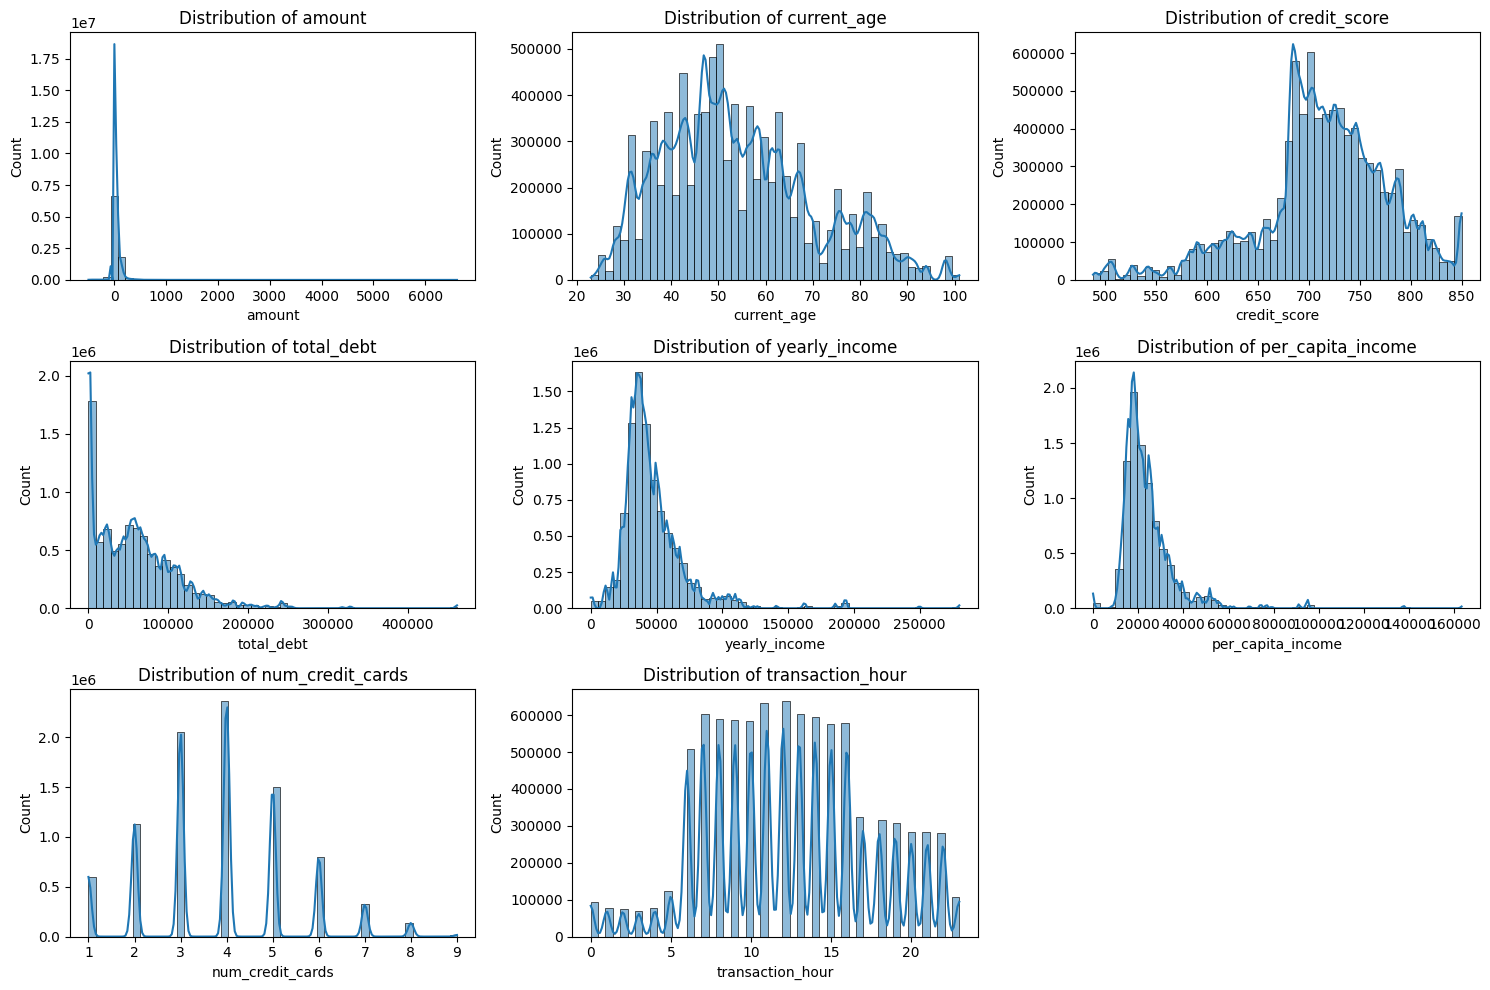

In [ ]:
# Selecting numerical features
numerical_features = ['amount', 'current_age', 'credit_score', 'total_debt',
                      'yearly_income', 'per_capita_income', 'num_credit_cards', 'transaction_hour']

# Plot histograms for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


Observations & Insights:

* amount (Transaction Amount):

  - Highly skewed (most transactions are small amounts, but a few extreme high values exist).

  - Potential Outliers (some transactions exceed 6000+, which might be suspicious).
  - Action: Log transformation can reduce skewness.
Flag very high transactions as potential anomalies for fraud detection.

* current_age (Age of User):
  - Approximately normal distribution with a peak around 30-60 years old.
Very few users above 80 years old (may need verification).
  - Action: Check if extremely old values (e.g., 100+ years) are valid or data errors.
* credit_score:
  - Bimodal distribution with peaks around 600-700 and 800+.
Very few values below 500 and above 850.
  - Action: Investigate users with extremely low or high credit scores.
Consider scaling (MinMaxScaler or StandardScaler) for modeling.
* total_debt:
  - Highly skewed distribution (most users have low debt, but a few have extreme amounts). Some users have zero debt, while others exceed $400,000+.
  - Action: Outlier detection needed (possible fraudulent cases with massive debts). Consider log transformation to normalize extreme values.

* yearly_income:
  - Right-skewed distribution (most users have low income, some very high).
Majority earn below $100,000 but some exceed $250,000+.

  - Action: Similar to debt, log transformation can help normalize the range.
* per_capita_income:
  - Extreme skewness (most users fall under $20,000, but some exceed $500,000+).
  - Action: Possible data errors for very high values → need further checks.
* num_credit_cards
  - Multimodal distribution (distinct peaks at 1, 2, 3, 5, 6+). Possible card ownership limit influencing peaks.
  - Action: No scaling needed, but consider converting to a categorical variable (e.g., low, medium, high).
* transaction_hour:
  - Uniform-like pattern (some peaks, likely due to business hours). Possible higher fraud rates at night (to investigate in Bivariate Analysis).
  - Action: Keep as-is (already binned into meaningful hour groups).

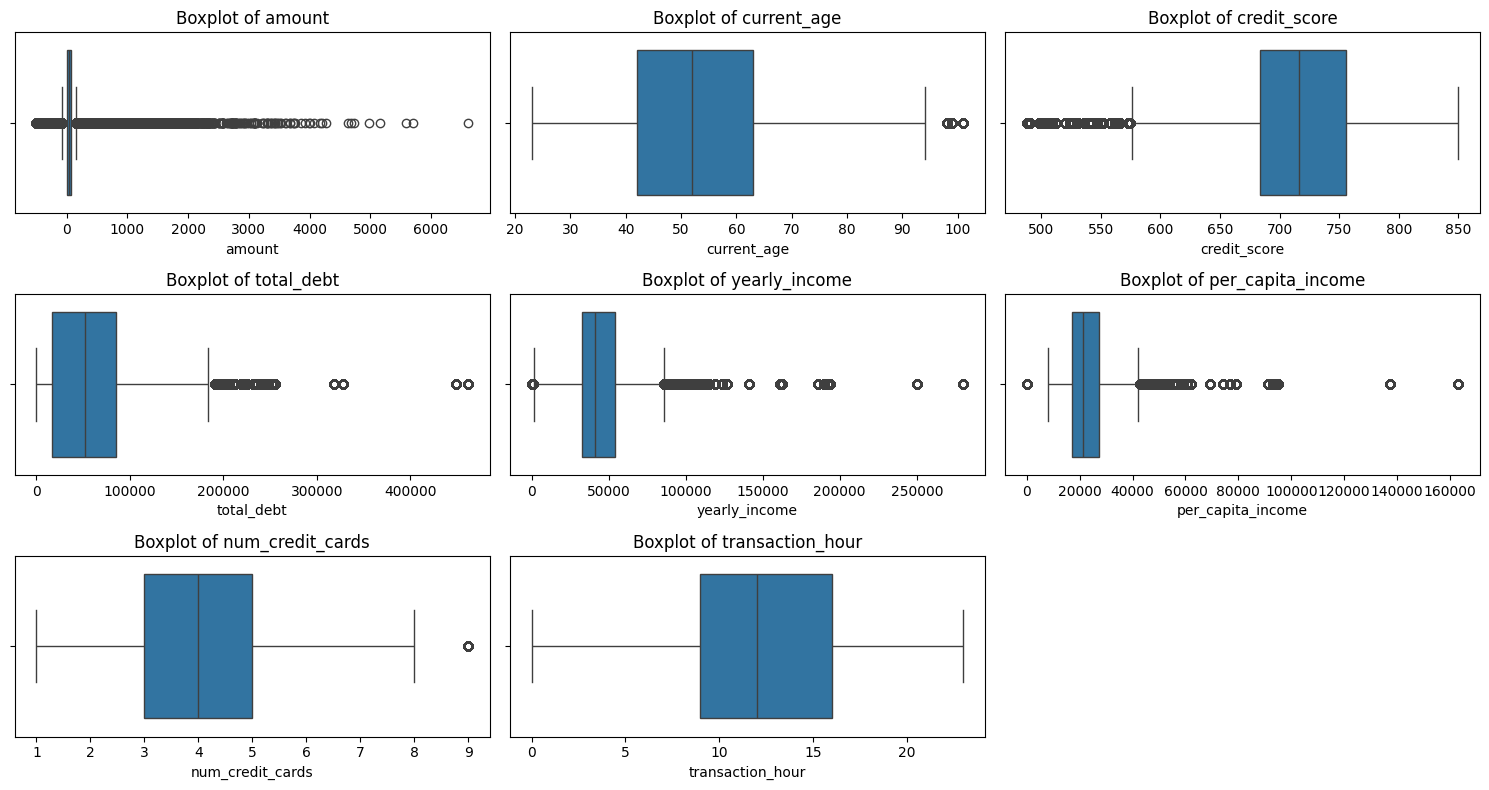

In [ ]:
# Boxplot for outlier detection
plt.figure(figsize=(15,8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


In [8]:
# Winsorizing skewed variables (capping extreme values)
df['amount'] = winsorize(df['amount'], limits=[0, 0.01])  # Capping top 1%
df['total_debt'] = winsorize(df['total_debt'], limits=[0, 0.01])
df['yearly_income'] = winsorize(df['yearly_income'], limits=[0, 0.01])
df['per_capita_income'] = winsorize(df['per_capita_income'], limits=[0, 0.01])

In [9]:
# Log transformation for highly skewed features
df['amount'] = np.log1p(df['amount'].clip(lower=1))
df['total_debt'] = np.log1p(df['total_debt'].clip(lower=1))
df['yearly_income'] = np.log1p(df['yearly_income'].clip(lower=1))
df['per_capita_income'] = np.log1p(df['per_capita_income'].clip(lower=1))

I will plot now post winsorization and log to view.

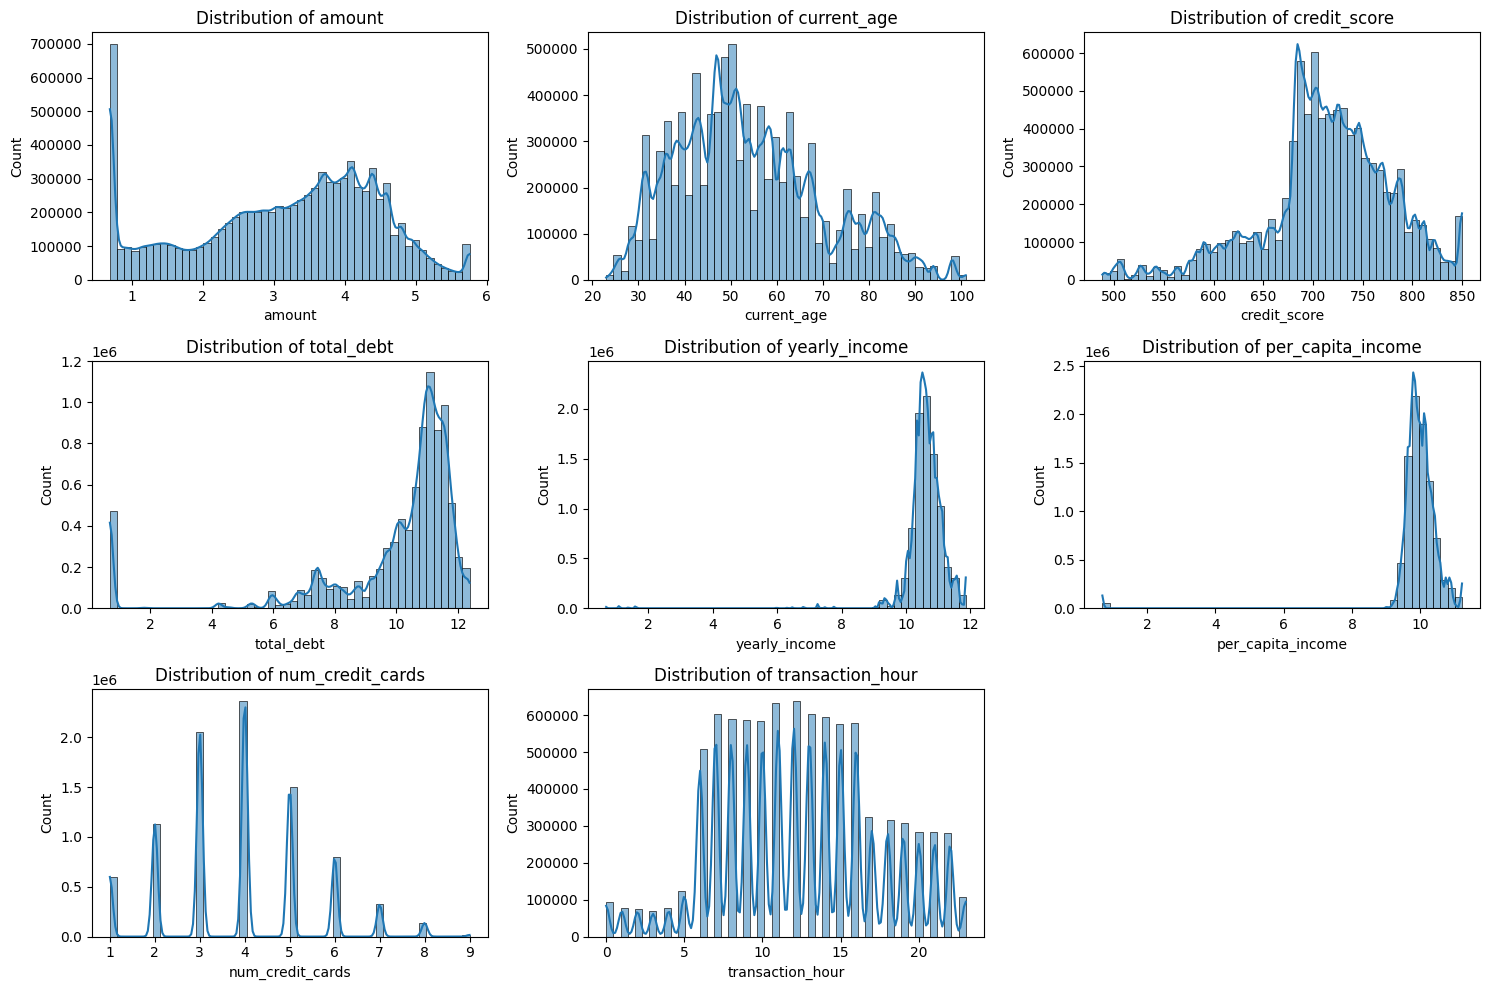

In [13]:
numerical_features = ['amount', 'current_age', 'credit_score', 'total_debt',
                      'yearly_income', 'per_capita_income', 'num_credit_cards', 'transaction_hour']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

amount – Looks much smoother and now follows a more normal-like distribution.

total_debt, yearly_income, per_capita_income – Skewness is significantly reduced, making them more suitable for modeling.

credit_score – Distribution remains similar but is naturally right-skewed (which is expected).

current_age – Distribution remains unchanged, as expected. No transformation was applied.

num_credit_cards, transaction_hour – No major changes needed, their distribution is appropriate.

@modelers --> normalize before starting with the model.

*Categorical Variables*

<ipython-input-35-a58290029f3e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-35-a58290029f3e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-35-a58290029f3e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-35-a58290029f3e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




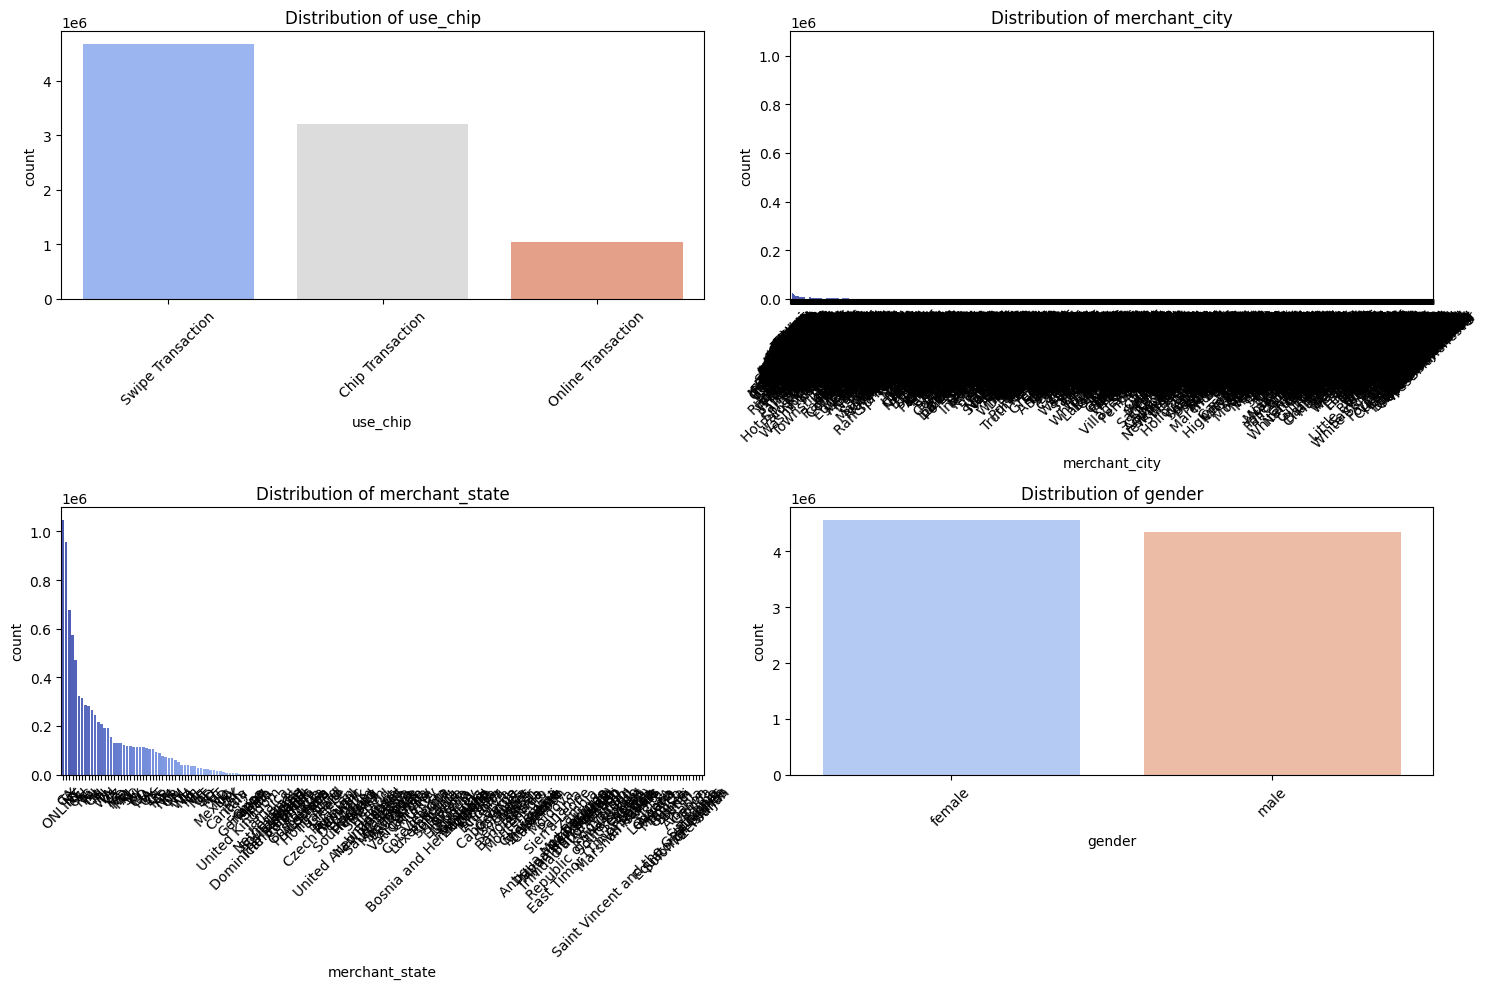

In [ ]:
cat_features = ["use_chip", "merchant_city", "merchant_state", "gender"]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, palette="coolwarm", order=df[feature].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

merchant_city has high-cardinality and impractical to encode. I will disregard it.

In [14]:
df['merchant_state'].nunique()

200

Since merchant_state has 200 unique values, encoding it directly would add 199 new columns, which is too complex and inefficient. Since we don’t need all 200 states, I will keep only the most frequent ones (top 10) and group the rest into an "Other" category.

In [10]:
top_states = df['merchant_state'].value_counts().nlargest(10).index  # Keep top 10
df['merchant_state'] = df['merchant_state'].apply(lambda x: x if x in top_states else "Other")
top_states

Index(['ONLINE', 'CA', 'TX', 'NY', 'FL', 'OH', 'IL', 'NC', 'PA', 'MI'], dtype='object', name='merchant_state')

In [13]:
df['merchant_state'].value_counts()

,count
merchant_state,
Other,3718073
ONLINE,1047865
CA,956356
TX,677139
NY,574521
FL,469600
OH,324098
IL,313592
NC,286937


<ipython-input-17-9f9c7ffe981c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['merchant_state'], order=df['merchant_state'].value_counts().index, palette="coolwarm")


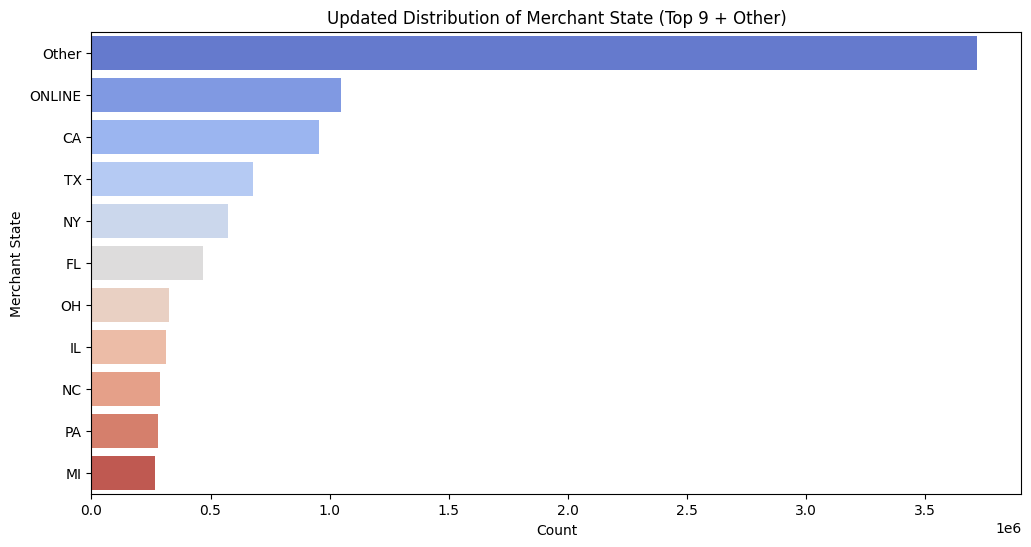

In [17]:
plt.figure(figsize=(12, 6))

# Plot updated merchant_state distribution
sns.countplot(y=df['merchant_state'], order=df['merchant_state'].value_counts().index, palette="coolwarm")

# Add labels and title
plt.xlabel("Count")
plt.ylabel("Merchant State")
plt.title("Updated Distribution of Merchant State (Top 9 + Other)")

# Show plot
plt.show()

**Bivariate Analysis:**

*Numerical vs Target*

<ipython-input-9-b0bc96b1c87a>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-9-b0bc96b1c87a>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-9-b0bc96b1c87a>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-9-b0bc96b1c87a>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-9-b0bc96b1c87a>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be remo

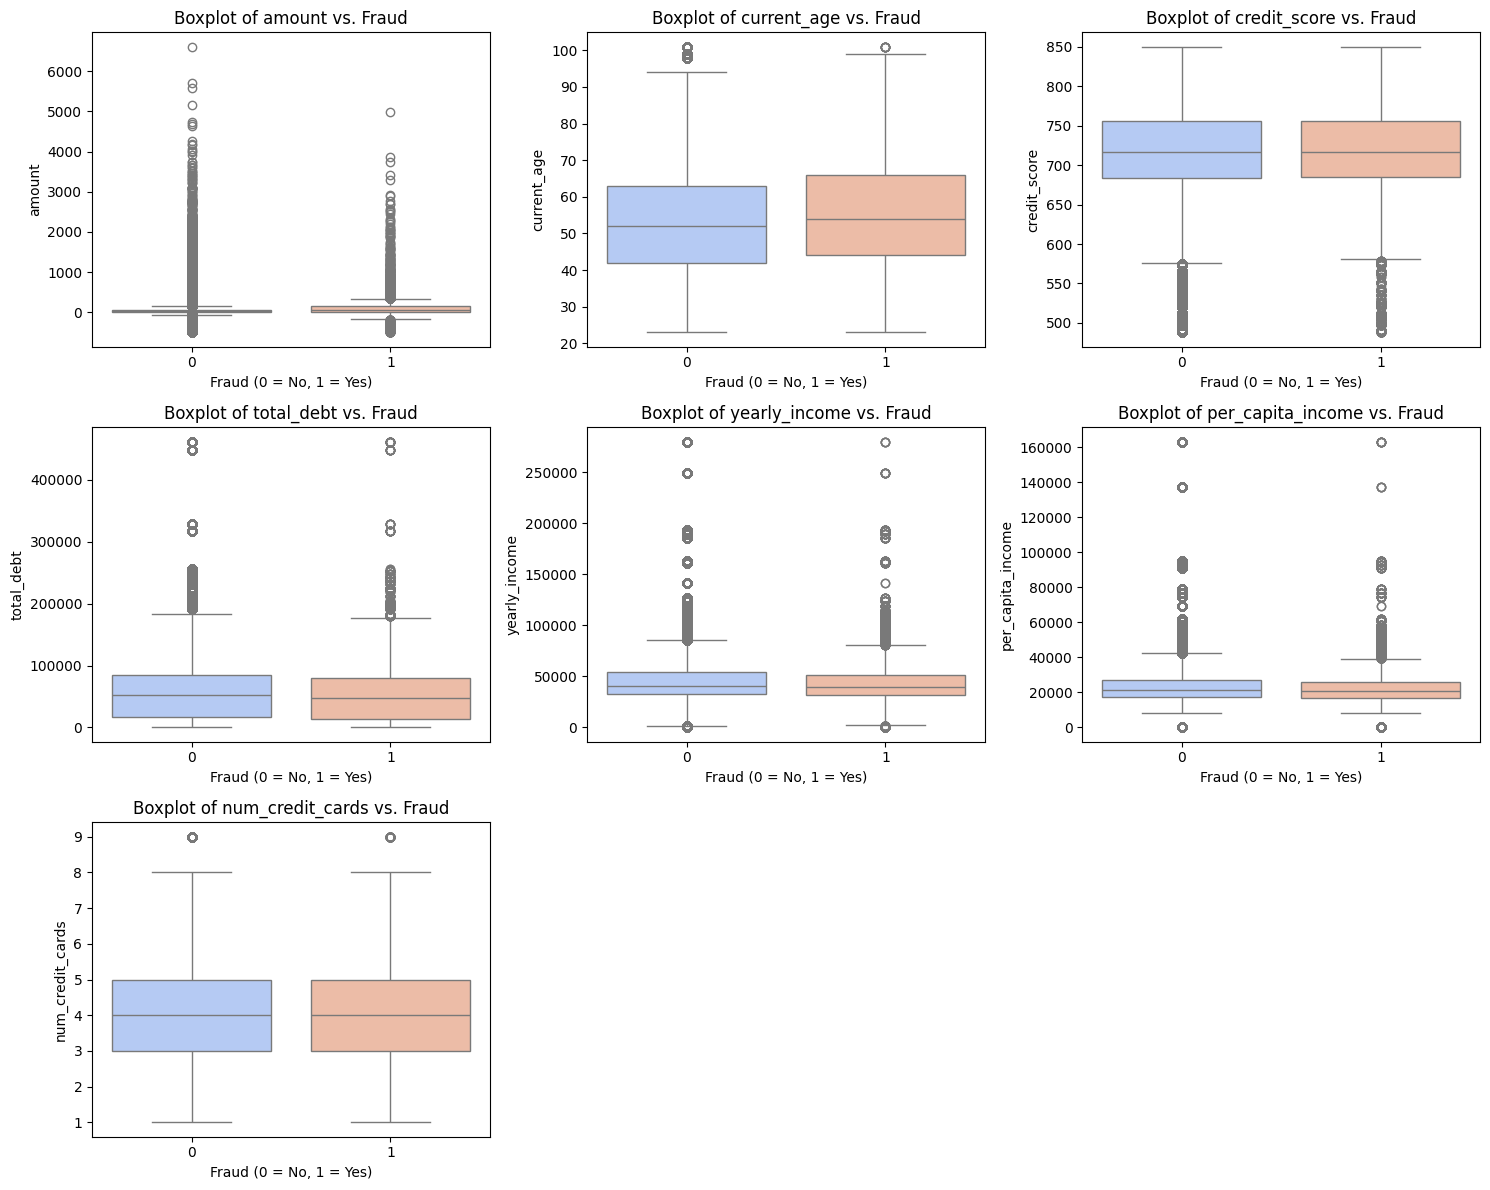

In [9]:
numerical_features = ['amount', 'current_age', 'credit_score', 'total_debt',
                      'yearly_income', 'per_capita_income', 'num_credit_cards']
plt.figure(figsize=(15, 12))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df['Target'], y=df[feature], palette="coolwarm")
    plt.title(f"Boxplot of {feature} vs. Fraud")
    plt.xlabel("Fraud (0 = No, 1 = Yes)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


1) Amount vs. Fraud

The medians of transaction amounts for fraud vs. non-fraud cases appear similar.
However, there seems to be a wider spread in fraud cases.

Outliers: There are extreme values, but they exist in both fraud and non-fraud cases.

Possible Conclusion: Transaction amount alone may not be a strong fraud
predictor but could be useful in combination with other factors.

2)  Current Age vs. Fraud

Fraudulent transactions seem to have a lower median age than non-fraud cases.
The spread is slightly wider for fraud cases, suggesting younger individuals might be more likely associated with fraud.

Possible Conclusion: Age could be an important feature, possibly linked to tech-savviness or risk-taking behavior.

3) Credit Score vs. Fraud

Fraudulent cases tend to have lower credit scores on average.
The boxplot shows that fraud cases have a wider spread but a slightly lower median credit score.

Possible Conclusion: Lower credit scores could indicate a higher likelihood of fraudulent behavior.

4) Total Debt vs. Fraud

Fraudulent cases tend to have higher total debt values.
Non-fraud cases are more concentrated in lower total debt ranges.

Possible Conclusion: Higher debt levels may be associated with financial distress, which could increase the likelihood of fraud.

5) Yearly Income vs. Fraud

The distributions appear similar, but fraudulent cases have a wider spread.
Fraud cases may not be strictly dependent on income, as both low and high incomes exist in fraud.

Possible Conclusion: Income alone may not strongly predict fraud, but in combination with other factors, it might be useful.

6) Per Capita Income vs. Fraud

The spread and median seem almost identical for fraud vs. non-fraud.

Possible Conclusion: Per capita income does not seem to have a strong relationship with fraud.

7) Number of Credit Cards vs. Fraud

Fraudulent cases seem to have a slightly higher median number of credit cards.
Outliers: A few cases exist where individuals with many credit cards are involved in fraud.

Possible Conclusion: Multiple credit cards could indicate a higher risk of fraud.

*Categorical vs Target*

<ipython-input-20-bddce5c3e682>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rates = df.groupby(feature)["Target"].mean().sort_values(ascending=False)
<ipython-input-20-bddce5c3e682>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rates.index, y=fraud_rates.values, palette="coolwarm")
<ipython-input-20-bddce5c3e682>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rates.index, y=fraud_rates.values, palette="coolwarm")
<ipython-input-20-bddce5c3e682>:11: FutureWarning: 

P

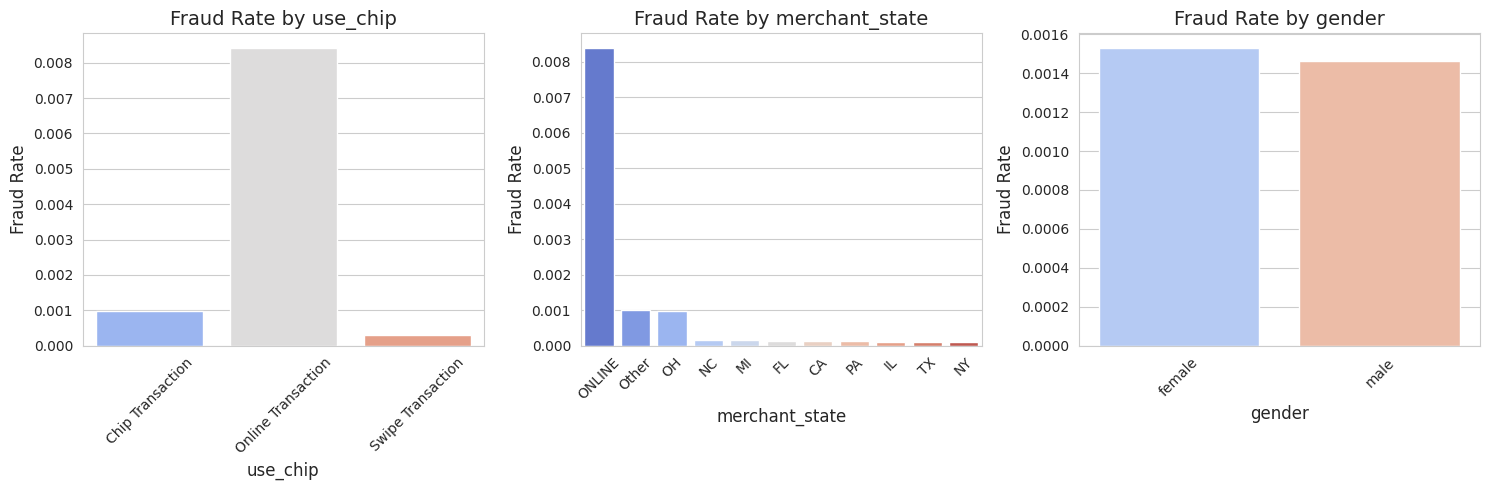

In [20]:
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")

# List of categorical variables to analyze
categorical_features = ["use_chip", "merchant_state", "gender"]

# Plot each categorical variable
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    fraud_rates = df.groupby(feature)["Target"].mean().sort_values(ascending=False)
    sns.barplot(x=fraud_rates.index, y=fraud_rates.values, palette="coolwarm")

    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Fraud Rate", fontsize=12)
    plt.title(f"Fraud Rate by {feature}", fontsize=14)
    plt.xticks(rotation=45)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

1) use_chip (Transaction Type) vs. Fraud
Online Transactions have the highest fraud rate (~0.009).
Swipe Transactions have a very low fraud rate.
Chip Transactions show the lowest fraud rate.

Interpretation:
This suggests that fraud is more likely to occur in online transactions, possibly due to weaker authentication measures compared to in-person chip transactions.

2) merchant_state vs. Fraud
ONLINE transactions have the highest fraud rate, which aligns with the previous insight.
Most physical states have significantly lower fraud rates.
"Other" states have slightly elevated fraud rates but are still much lower than online transactions.

Interpretation:
Fraud seems to be more prevalent in online transactions rather than specific locations. This reinforces that fraud prevention strategies should prioritize online purchases.

3) gender vs. Fraud
Females have a slightly higher fraud rate ~0.0016 than males ~0.0015.
The difference is minimal, meaning gender might not be a strong fraud predictor.

Interpretation:
Gender does not seem to have a significant impact on fraud likelihood. The small difference could be due to transaction behaviors rather than inherent fraud tendencies.

Correlation Heatmap

In [10]:
print(df.columns)


Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'Target', 'current_age', 'retirement_age', 'birth_year', 'birth_month',
       'gender', 'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'transaction_hour'],
      dtype='object')


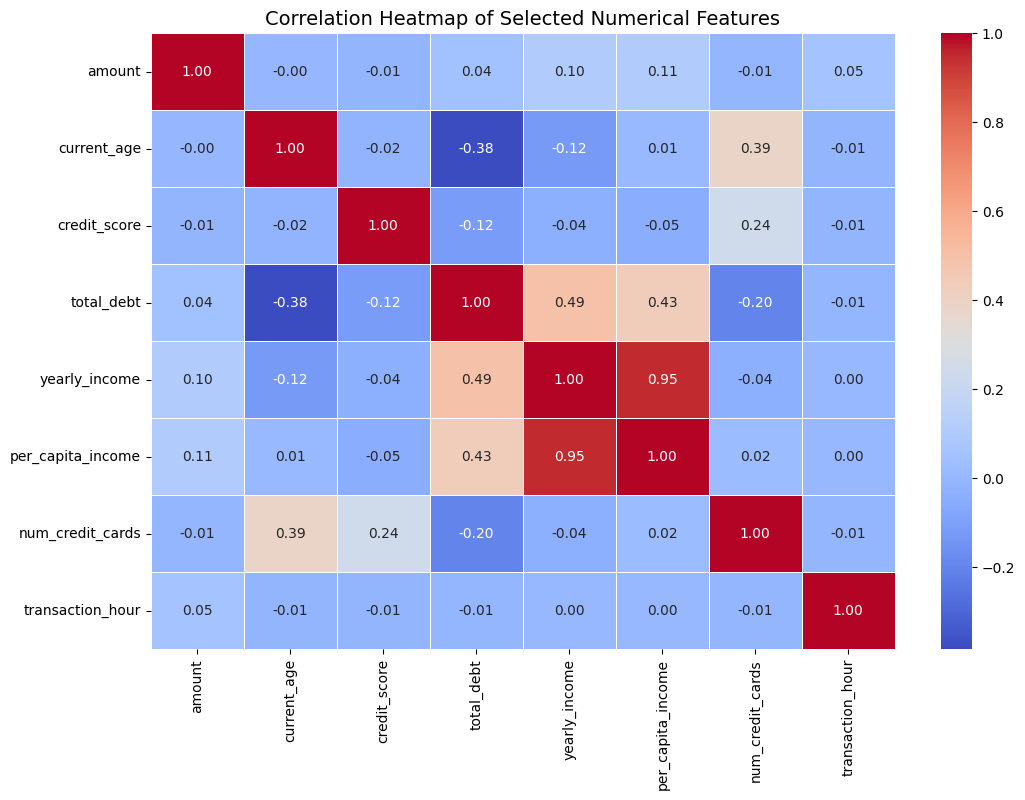

In [11]:
numerical_features = ['amount', 'current_age', 'credit_score', 'total_debt',
                      'yearly_income', 'per_capita_income', 'num_credit_cards', 'transaction_hour']

correlation_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Titles and labels
plt.title("Correlation Heatmap of Selected Numerical Features", fontsize=14)
plt.show()

* Highly Correlated Features (Multicollinearity Concern)

Yearly Income & Per Capita Income (0.95) → Very strong positive correlation.

Total Debt & Yearly Income (0.49) → Moderate positive correlation.

Total Debt & Per Capita Income (0.43) → Moderate correlation.

Action: Since Yearly Income and Per Capita Income are almost identical (0.95), we should consider dropping one to reduce redundancy in the model.

* Moderate Correlation:

Num Credit Cards & Current Age (0.39) → Older individuals tend to have more credit cards.

Credit Score & Num Credit Cards (0.24) → More credit cards slightly correlate with better credit scores.

Insight: These variables may be useful for modeling fraud, as they relate to user financial behavior.

* Weak or No Correlation

Transaction Hour has no meaningful correlation with other features.

Amount is uncorrelated with most features (-0.01 to 0.11).

Credit Score has weak correlations (-0.12 to 0.24).

Action: These features should not be removed but should be analyzed further in feature importance ranking during model training.



Now i will check for multicollinearity using VIF

In [14]:
# dropped per_capita_income due to high correlation

# Define features after dropping per_capita_income
selected_numerical_features = ['amount', 'current_age', 'credit_score', 'total_debt',
                               'yearly_income', 'num_credit_cards', 'transaction_hour']

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = selected_numerical_features
vif_data["VIF"] = [variance_inflation_factor(df[selected_numerical_features].values, i)
                    for i in range(len(selected_numerical_features))]

# Display VIF results
print(vif_data)


            Feature        VIF
0            amount   1.294783
1       current_age  14.580468
2      credit_score  23.801440
3        total_debt   3.298917
4     yearly_income   6.219638
5  num_credit_cards   8.755194
6  transaction_hour   6.649433


@modelers consider dropping credit_score if the model is not performing well. I will keep it since i cant tell now if it might improve the model performance without increasing the variance.

**Multi-variate Analysis:**

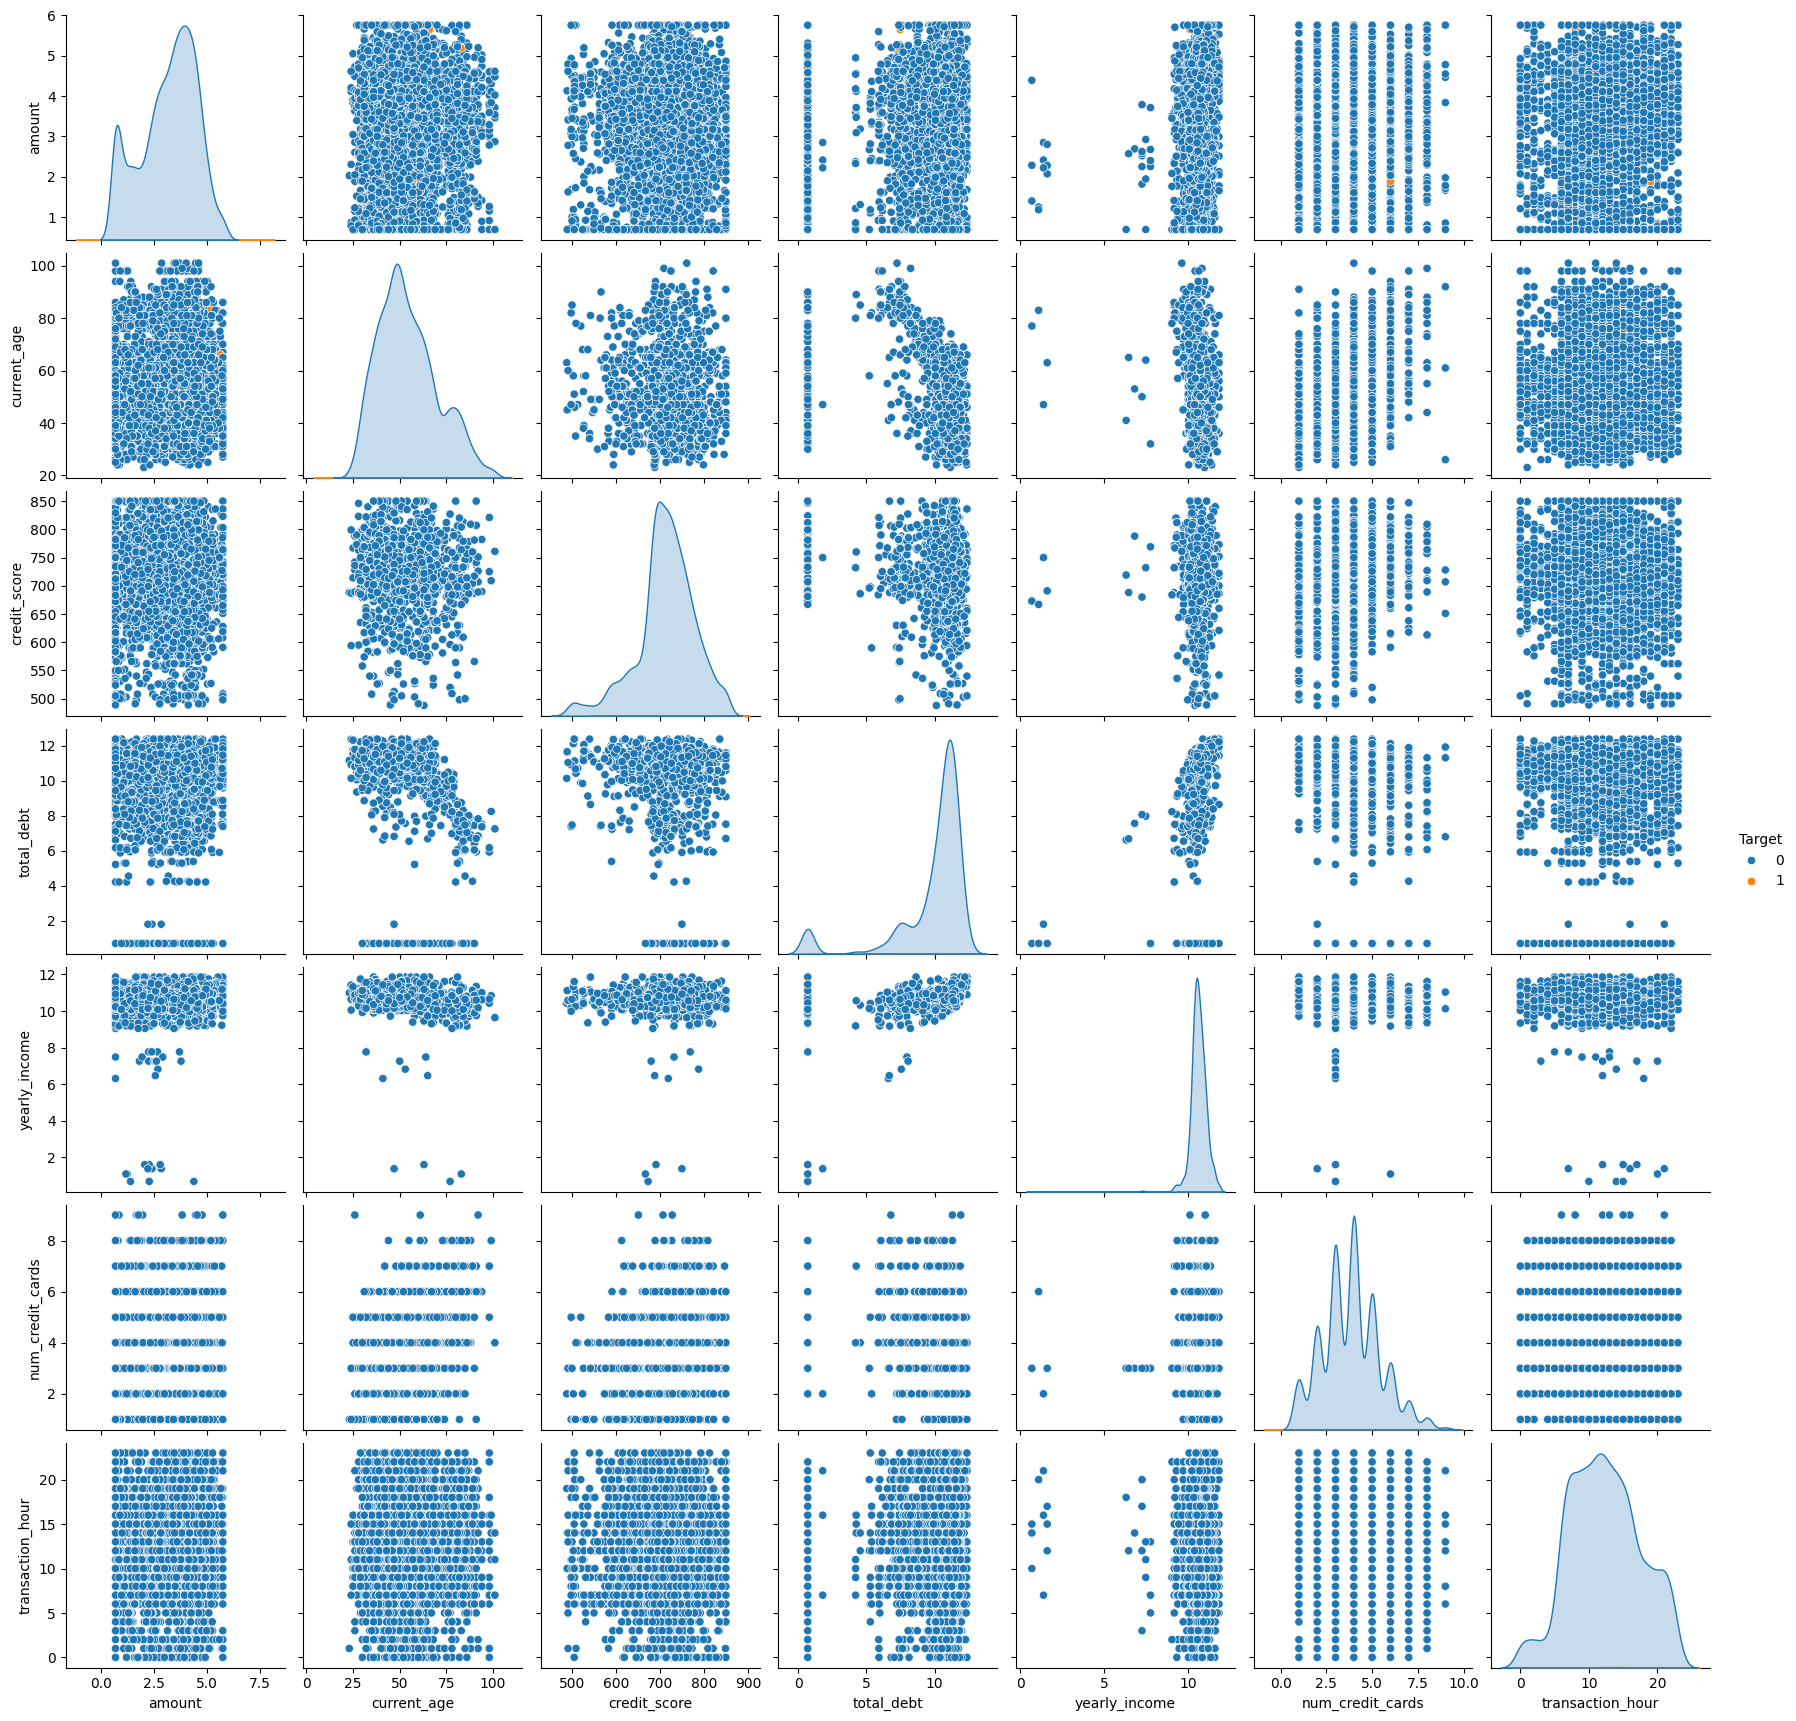

In [13]:
num_features = ['amount', 'current_age', 'credit_score', 'total_debt', 'yearly_income', 'num_credit_cards', 'transaction_hour']

# Sample the data to speed up the visualization
df_sample = df.sample(5000, random_state=42)

sns.pairplot(df_sample, hue="Target", diag_kind="kde", vars=num_features)
plt.show()

<ipython-input-14-69ea72f6538c>:4: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



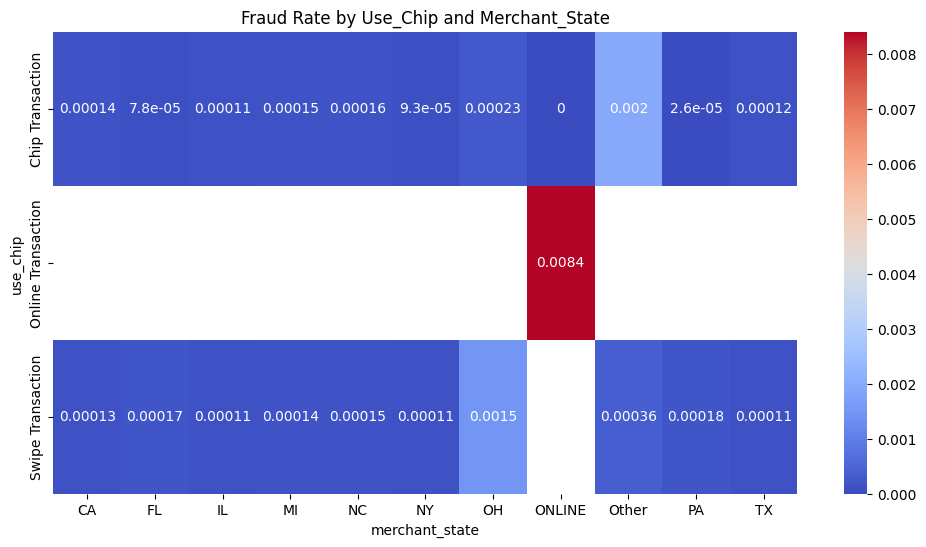

In [14]:
plt.figure(figsize=(12,6))

# Fraud rate by use_chip and merchant_state
sns.heatmap(df.pivot_table(index="use_chip", columns="merchant_state", values="Target", aggfunc="mean"), annot=True, cmap="coolwarm")
plt.title("Fraud Rate by Use_Chip and Merchant_State")
plt.show()

Interaction Terms:

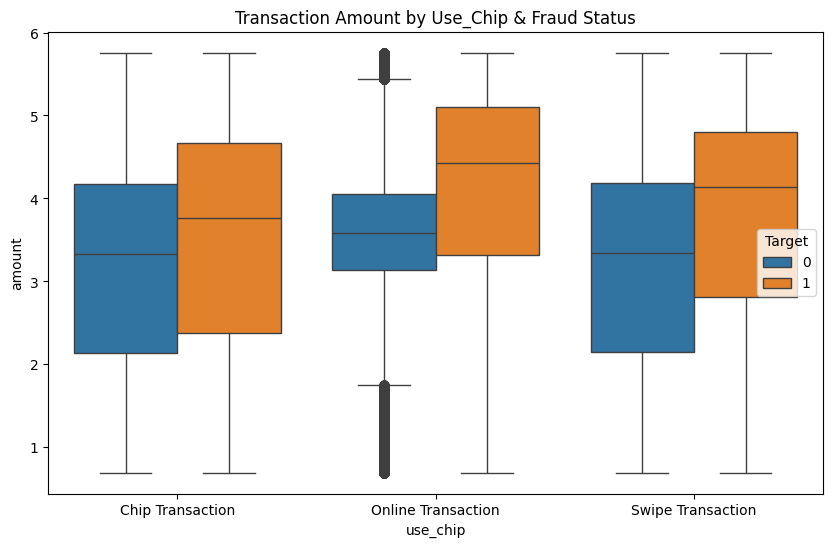

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x="use_chip", y="amount", hue="Target", data=df)
plt.title("Transaction Amount by Use_Chip & Fraud Status")
plt.show() 

Fraudulent transactions (orange) generally have higher amounts

* Across all three transaction types (Chip, Online, Swipe), fraud transactions
tend to have higher median values than non-fraud ones.
* This suggests that fraudsters tend to perform higher-value transactions.

Online transactions show a distinct pattern



* Lower variation in transaction amount (more tightly packed box)
* Some high-value outliers may indicate targeted fraud.
* Fraudulent online transactions seem to have a slightly lower median compared to Swipe.

Swipe transactions have a wider spread

* Higher fraud levels compared to chip transactions.
* More fraudulent high-value transactions are evident.
* Possible indication that swipe transactions are more vulnerable.

Chip transactions appear to be the most secure

* Fraudulent transactions exist but are less extreme in amount.
* The median transaction amount for fraud and non-fraud is closer compared to Swipe and Online.

Encoding Categorical Variables:

In [11]:
# One-Hot Encoding for categorical features
df = pd.get_dummies(df, columns=['use_chip', 'merchant_state', 'gender'], dtype=int)

In [14]:
df.head()

,id,date,client_id,card_id,amount,merchant_id,merchant_city,zip,mcc,Target,...,merchant_state_MI,merchant_state_NC,merchant_state_NY,merchant_state_OH,merchant_state_ONLINE,merchant_state_Other,merchant_state_PA,merchant_state_TX,gender_female,gender_male
0,7475327,2010-01-01 00:01:00,1556,2972,0.693147,59935,Beulah,58523,5499,0,...,0,0,0,0,0,1,0,0,1,0
1,7475328,2010-01-01 00:02:00,561,4575,2.745346,67570,Bettendorf,52722,5311,0,...,0,0,0,0,0,1,0,0,0,1
2,7475329,2010-01-01 00:02:00,1129,102,4.394449,27092,Vista,92084,4829,0,...,0,0,0,0,0,0,0,0,0,1
3,7475332,2010-01-01 00:06:00,848,3915,3.858833,13051,Harwood,20776,5813,0,...,0,0,0,0,0,1,0,0,0,1
4,7475333,2010-01-01 00:07:00,1807,165,1.759581,20519,Bronx,10464,5942,0,...,0,0,1,0,0,0,0,0,1,0


## **Feature Scaling**

In [12]:
numerical_features = ['amount', 'current_age', 'credit_score', 'total_debt',
                      'yearly_income', 'num_credit_cards', 'transaction_hour']

scaler = StandardScaler()

# Apply scaling ONLY on numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [13]:
# Define independent (X) and dependent (y) variables
X = df.drop(columns=['Target'])  # Drop the target column
y = df['Target']  # Target variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the split
print("Train Set:", X_train.shape, y_train.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (7131970, 38) (7131970,)
Test Set: (1782993, 38) (1782993,)


In [ ]:
# Feature Selection
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                    'Importance': rf_model.feature_importances_})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Names")
plt.title("Feature Importance from Random Forest")
plt.show()

Next:
* Run feature selection
* Causal Inference
* Feature importance
* Make sure to handle
* Handle class imbalance
* Run models and iterate